# 3-Day Discovery Metric

In [1]:
#Necessary files needed for plotting the curves and manipulating the data.

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astropy as astro
import random
import itertools
from astropy.table import Table,Column, vstack
from astropy.io import ascii
from astropy.cosmology import WMAP9 as cosmo
from scipy.interpolate import interp1d
plt.rcParams["figure.figsize"] = (10,8)
%matplotlib inline
#We will need to grab the data from where it is saved on the computer.

#NS-NS
APR1215 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/APR4-1215.txt')
APR1314 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/APR4-1314.txt')
H41215 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/H4-1215.txt')
H41314 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/H4-1314.txt')
Sly135 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/Sly-135.txt')

#NS-BH
APR4Q3a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/APR4Q3a75.txt')
H4Q3a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/H4Q3a75.txt')
MS1Q3a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/MS1Q3a75.txt')
MS1Q7a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/MS1Q7a75.txt')

## Apparent Magnitude conversions

In [2]:
# Constants:
title = 22
subtitle = 20
axis = 16
ticksize = 12
legend = 12

redshift = 0.015


#Convert Absolute Magnitude to Apparent Magnitude

#app_mag: Merger Number -> Merger
#Converts the merger data from absolute magnitude to apparent magnitude.
def app_mag_dist(merger, distance):
    day=merger['day']
    u=app_mag_band_dist(merger['u'],distance)
    g=app_mag_band_dist(merger['g'],distance)
    r=app_mag_band_dist(merger['r'],distance)
    i=app_mag_band_dist(merger['i'],distance)
    z=app_mag_band_dist(merger['z'],distance)
    return Table([day, u, g, r, i, z], names=('day', 'u', 'g', 'r', 'i', 'z'))

#app_mag_band: ListofNumbers Number -> ListofNumbers
#converts all the absolute magnitudes into apparent magnitudes.
def app_mag_band_dist(data, distance):
    app_mag = 5*np.log10((distance*1e6)/10)+data
    return app_mag


def app_mag_redshift(merger, redshift):
    day=merger['day']
    u=app_mag_band_redshift(merger['u'],redshift)
    g=app_mag_band_redshift(merger['g'],redshift)
    r=app_mag_band_redshift(merger['r'],redshift)
    i=app_mag_band_redshift(merger['i'],redshift)
    z=app_mag_band_redshift(merger['z'],redshift)
    return Table([day, u, g, r, i, z], names=('day', 'u', 'g', 'r', 'i', 'z'))

#app_mag_band: ListofNumbers Number -> ListofNumbers
#converts all the absolute magnitudes into apparent magnitudes.
def app_mag_band_redshift(data, redshift):
    app_mag = 5*np.log10(lumo_dist(redshift)/10)+data
    return app_mag

#lumo_dist: Number -> Number
#converts redshift to luminosity distance
def lumo_dist(redshift):
    return cosmo.luminosity_distance(redshift).to(astro.units.pc).value

## Sigma and Random Magnitude Calculations

In [3]:
#Constants:
sigma_sys = 0.005
X = 1
t_vis = 30
parameters = Table([['m_sky', 'theta', 'gamma', 'k_m', 'C_m', 'm_5', 'del_C', 'del_C2', 'del_m_5'],
                    [22.9, 0.77, 0.037, 0.451, 22.92, 23.68, 0.67, 0.24, 0.21],
                    [22.3, 0.73, 0.038, 0.163, 24.29, 24.89, 0.21, 0.09, 0.15],
                    [21.2, 0.70, 0.039, 0.087, 24.33, 24.43, 0.11, 0.05, 0.14],
                    [20.5, 0.67, 0.039, 0.065, 24.20, 24.00, 0.08, 0.04, 0.13], 
                    [19.6, 0.65, 0.040, 0.043, 24.07, 24.45, 0.05, 0.03, 0.13],
                    [18.6, 0.63, 0.040, 0.138, 23.69, 22.60, 0.04, 0.02, 0.15,]],
                  names = ('parameters','u', 'g', 'r', 'i', 'z', 'y'))

def sigmas(mags, band, X=1, t_vis=30):
    sigmas = []
    for mag in mags:
        sigmas.append(sigma_1(mag, band, X, t_vis))
    return sigmas

def sigma_1(mag, band, X=1, t_vis=30):
    sigma1 = np.float(np.sqrt(sigma_sys**2 + sigma_rand(mag, band, parameters, X, t_vis)**2))
    return sigma1


def sigma_rand(mag, band, parameters, X=1, t_vis=30):
    gamma = parameters[band][np.where(parameters['parameters']=='gamma')]
    return np.float((0.04-gamma)*x(mag, band, parameters, X, t_vis) + gamma*x(mag, band, parameters, X, t_vis)**2)

def x(mag, band, parameters, X=1, t_vis=30):
    return np.float(10**(0.4*(mag-m_5(band, parameters, X, t_vis))))

def m_5(band, parameters=parameters, X=1, t_vis=30):
    C_m = parameters[band][np.where(parameters['parameters']=='C_m')]
    m_sky = parameters[band][np.where(parameters['parameters']=='m_sky')]
    theta = parameters[band][np.where(parameters['parameters']=='theta')]
    k_m = parameters[band][np.where(parameters['parameters']=='k_m')]
    m_5 = C_m+0.50*(m_sky-21)+2.5*np.log10(0.7/theta)+1.25*np.log10(t_vis/30)-k_m*(X-1)
    return np.float(m_5)

def rand_mags(merger):
    u = []
    g = []
    r = []
    i = []
    z = []
    days = np.array(merger['day'])
    for day in days:
        u.append(rand_mag(merger, 'u', day, 0))        
        g.append(rand_mag(merger, 'g', day, 1))        
        r.append(rand_mag(merger, 'r', day, 2))       
        i.append(rand_mag(merger, 'i', day, 3))       
        z.append(rand_mag(merger, 'z', day, 4))
    return Table([days, u, g, r, i, z], names=('day', 'u', 'g', 'r', 'i', 'z'))

def rand_mag(merger, band, day, number, X=1, t_vis=30):
    if interpolate(merger)[number](day) > m_5(band, parameters, X, t_vis):
        m_true = m_5(band, parameters, X, t_vis)
        
    else:
        m_true = interpolate(merger)[number](day)
    
    stdev = sigma_1(m_true, band)        
    
    if m_true == m_5(band, parameters, X, t_vis):
        m_obs = m_5(band, parameters, X, t_vis)
    else:
        m_obs = np.random.normal(m_true, stdev)
    return m_obs

## Discovery Metric (3-day)

In [4]:
trial_num = 2000

def Analyze(merger):
    time = weather_output()
    distances0 = rand_dists()
    colors = measure_color(merger, time, distances0)
    distances = colors['Distance (Mpc)']
    discoveries = []
    for i in range(len(colors['Color (Epoch 1)'])):
        
        if colors['Color (Epoch 1)'][i] > 0.5 and \
        np.divide(colors['Color (Epoch 1)'][i], colors['Sigmas (Epoch 1)'][i]) > 3 and \
        colors['Color (Epoch 2)'][i] > 0.5 and \
        np.divide(colors['Color (Epoch 2)'][i], colors['Sigmas (Epoch 2)'][i]) > 3 and \
        colors['$\Delta m_{3}$ (z-band)'][i] > 1.0 and \
        np.divide(colors['$\Delta m_{3}$ (z-band)'][i], colors['Sigmas (z-band)'][i]) > 3:
            discoveries.append(1)
        else:
            discoveries.append(0)
            
    return Table([colors['Band'], distances, discoveries], names=('Band', 'Distance (Mpc)', 'Discovery'))


def measure_color(merger0, time0, distances0):
    u = measure_color_band(merger0, time0, distances0, 'u')
    g = measure_color_band(merger0, time0, distances0, 'g')
    r = measure_color_band(merger0, time0, distances0, 'r')
    i = measure_color_band(merger0, time0, distances0, 'i')
    table = vstack([u,g,r,i])
    return table


def measure_color_band(merger0, time0, distances0, band):
    t_vis = 30
    color_list1 = []
    color_sigs1 = []
    color_list2 = []
    color_sigs2 = []
    band_list = []
    delta_z = []
    sig_z = []
    
    for t1,t2,dist in itertools.zip_longest(time0['Epoch 1'], time0['Epoch 2'], distances0):
        
        #apparent mag conversion
        merger = app_mag_dist(merger0, dist)
        
        
        #band choice
        band = band
        band_list.append(band+'-z')
        
        #airmass
        X = random.random()+1
        
        #LSST calculation
        LSST = {'u': m_5('u', parameters, X, t_vis),
            'g': m_5('g', parameters, X, t_vis),
            'r': m_5('r', parameters, X, t_vis),
            'i': m_5('i', parameters, X, t_vis),
            'z': m_5('z', parameters, X, t_vis)} 
        
        #color, delta-z, and sigma calculations
        mag1 = get_mag(merger, band, t1, LSST, X, t_vis)
        z1 = get_mag(merger, 'z', t1, LSST, X, t_vis)
        mag2 = get_mag(merger, band, t2, LSST, X, t_vis)
        z2 = get_mag(merger, 'z', t2, LSST, X, t_vis)
        
        sig1 = sigma_1(mag1, band, X, t_vis)
        sigz1 = sigma_1(z1, 'z', X, t_vis)
        sig2 = sigma_1(mag2, band, X, t_vis)
        sigz2 = sigma_1(z2, 'z', X, t_vis)
        
        color1 = np.subtract(mag1,z1)
        sigs1 = np.sqrt(np.add(np.square(sig1), np.square(sigz1)))
        color2 = np.subtract(mag2,z2)
        sigs2 = np.sqrt(np.add(np.square(sig2), np.square(sigz2)))
        z = np.subtract(z2,z1)
        sigz = np.sqrt(np.add(np.square(sigz1), np.square(sigz2)))
        
        #append lists
        color_list1.append(color1)
        color_sigs1.append(sigs1)
        color_list2.append(color2)
        color_sigs2.append(sigs2)
        delta_z.append(z)
        sig_z.append(sigz)
        
    return Table([band_list, distances0, color_list1, color_list2, color_sigs1, color_sigs2, delta_z, sig_z],
                 names=('Band', 'Distance (Mpc)','Color (Epoch 1)', 'Color (Epoch 2)',
                        'Sigmas (Epoch 1)', 'Sigmas (Epoch 2)', '$\Delta m_{3}$ (z-band)', 'Sigmas (z-band)'))


def weather_output():
    t1 = []
    t2 = []
    for i in range(trial_num):
        t = random.random()+1.06
        t01 = weather_simulator(t)
        t02 = weather_simulator(t01+3)
        t1.append(t01)
        t2.append(t02)
    return {'Epoch 1': t1, 'Epoch 2': t2}
    


def weather_simulator(time):
    weather = random.random()
    if weather < 0.8:
        time = time
    else:
        time = weather_simulator(time+1)
    return time


def rand_dists():
    distances = []
    for i in range(trial_num):
        distances.append(rand_dist())
    return distances


#detect: Merger String Number -> Boolean
#Determines if LSST can detect the light curve of a specific band at a specific time.
def detect(merger, band, time, LSST, X=1, t_vis=30):
    if band == 'u':
        mag_u = rand_mag(merger, band, time, 0, X, t_vis)
        return in_view(mag_u, LSST['u'])
    elif band == 'g':
        mag_g = rand_mag(merger, band, time, 1, X, t_vis)
        return in_view(mag_g, LSST['g'])
    elif band == 'r':
        mag_r = rand_mag(merger, band, time, 2, X, t_vis)
        return in_view(mag_r, LSST['r'])
    elif band == 'i':
        mag_i = rand_mag(merger, band, time, 3, X, t_vis)
        return in_view(mag_i, LSST['i'])
    elif band == 'z':
        mag_z = rand_mag(merger, band, time, 4, X, t_vis)
        return in_view(mag_z, LSST['z'])
    return

#in_view: Number Number -> Boolean
#Checks if LSST can detect the light curve based on magnitude.
def in_view(mag, LSST):
    if mag < LSST:
        return True
    else:
        return False
    return


def get_mag(merger, band, time, LSST, X=1, t_vis=30):
    mag = 0
    if detect(merger, band, time, LSST, X, t_vis)==True:
        if band == 'u':
            mag = rand_mag(merger, band, time, 0, X, t_vis)
        elif band == 'g':
            mag = rand_mag(merger, band, time, 1, X, t_vis)
        elif band == 'r':
            mag = rand_mag(merger, band, time, 2, X, t_vis)
        elif band == 'i':
            mag = rand_mag(merger, band, time, 3, X, t_vis)
        elif band == 'z':
            mag = rand_mag(merger, band, time, 4, X, t_vis)
    
    elif detect(merger, band, time, LSST, X, t_vis)==False:
        if band == 'u':
            mag = LSST['u']
        elif band == 'g':
            mag = LSST['g']
        elif band == 'r':
            mag = LSST['r']
        elif band == 'i':
            mag = LSST['i']
        elif band == 'z':
            mag = LSST['z']
            
    return mag

#rand_dist: Merger -> Number
#Picks a random distance from 0 to 200Mpc.
def rand_dist():
    x=random.uniform(-1,1)
    y=random.uniform(-1,1)
    z=random.uniform(-1,1)
    dist=np.sqrt(x**2+y**2+z**2)
    if dist < 1:
        return dist*200
    else:
        return rand_dist()
    return

#interpolate: Merger-> List of Interpolations
#Provides the necessary interpolation functions of the mergers in each associated photometric bands. 
def interpolate(merger):
    LSST_u=m_5('u', parameters, X, t_vis)
    LSST_g=m_5('g', parameters, X, t_vis)
    LSST_r=m_5('r', parameters, X, t_vis)
    LSST_i=m_5('i', parameters, X, t_vis)
    LSST_z=m_5('z', parameters, X, t_vis)
    approx='cubic'
    u=interp1d(merger['day'][np.isfinite(merger['u'])], merger['u'][np.isfinite(merger['u'])],
               kind=approx, bounds_error=False, fill_value=LSST_u)
    g=interp1d(merger['day'][np.isfinite(merger['g'])], merger['g'][np.isfinite(merger['g'])],
               kind=approx, bounds_error=False, fill_value=LSST_g)
    r=interp1d(merger['day'][np.isfinite(merger['r'])], merger['r'][np.isfinite(merger['r'])],
               kind=approx, bounds_error=False, fill_value=LSST_r)
    i=interp1d(merger['day'][np.isfinite(merger['i'])], merger['i'][np.isfinite(merger['i'])],
               kind=approx, bounds_error=False, fill_value=LSST_i)
    z=interp1d(merger['day'][np.isfinite(merger['z'])], merger['z'][np.isfinite(merger['z'])],
               kind=approx, bounds_error=False, fill_value=LSST_z)
    return [u, g, r, i, z]

In [5]:
APR1215_Data = Analyze(APR1215)

In [6]:
APR1314_Data = Analyze(APR1314)

In [7]:
H41215_Data = Analyze(H41215)

In [8]:
H41314_Data = Analyze(H41314)

In [9]:
Sly135_Data = Analyze(Sly135)

In [10]:
APR4Q3a75_Data = Analyze(APR4Q3a75)

In [11]:
H4Q3a75_Data = Analyze(H4Q3a75)

In [12]:
MS1Q3a75_Data = Analyze(MS1Q3a75)

In [13]:
MS1Q7a75_Data = Analyze(MS1Q7a75)

## Efficiency Plots

In [14]:
#filter_hits: Table -> Table
#Filters the table to only have data containing kilonova hits.
def filter_hits2(table):
    hits = np.where(table['Discovery'] == 1)[0]
    return table[hits]

#filter_band: Table String -> Table
#Filters the table to only have data containing the designated band.
def filter_band2(table, band):
    band_filter=np.where(table['Band']==band)[0]
    return table[band_filter]

#filter_hits: Table -> Table
#Filters the table to only have data containing the distance (Mpc).
def filter_dist2(table):
    return table['Distance (Mpc)']


#efficiency: Table String -> ListofNumbers
#Converts the number of detections into a fraction: number of succesful detections over the total number of
# observations at that distance.
def efficiency2(merger_table, band):
    countx, binx=np.histogram(np.array(filter_dist2(filter_band2(filter_hits2(merger_table), band))),
                              bins=50, range=(0,200))
    county, biny=np.histogram(np.array(filter_dist2(filter_band2(merger_table, band))), bins=50, range=(0,200))
    np.seterr(divide='ignore', invalid='ignore')
    counts=countx/county
    for i in range(len(counts)):
        if np.isnan(counts[i]):
            counts[i]=0
    return counts*100, binx


#plot_bar: Table String -> Image
#Plots a bar graph of the efficiency of the LSST as a function of distance(Mpc).
def plot_bar2(table, name):
    plt.figure(figsize=(10,11))
    ax1 = plt.subplot(411)
    ax1b = ax1.twinx()
    ax2 = plt.subplot(412)
    ax2b = ax2.twinx()
    ax3 = plt.subplot(413)
    ax3b = ax3.twinx()
    ax4 = plt.subplot(414)
    ax4b = ax4.twinx()
    
    #________________________________________________________________________________________________
    
    n1b, bins1b = np.histogram(np.array(filter_dist2(filter_band2(table, 'u-z'))), 
                             bins = 50, range=(0,200))
    
    center1 = (efficiency2(table, 'u-z')[1][:-1] + efficiency2(table, 'u-z')[1][1:]) / 2
    width1 = (efficiency2(table, 'u-z')[1][1] - efficiency2(table, 'u-z')[1][0])
    
    ax1.bar(center1, efficiency2(table, 'u-z')[0],
           width=width1, align='center', facecolor='blue', edgecolor='black', label='Efficiency')
    ax1b.plot(center1, n1b, 'o-', color='orange', markeredgecolor='black', label='Total Observations')
    
    
    handles1,labels1 = ax1b.get_legend_handles_labels()

    handles1 =handles1[::-1]
    labels1 = labels1[::-1]   
    
    ax1.legend(handles1, labels1, bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0., prop={'size':12})
    
    ax1.set_title('u $-$ z', fontsize=subtitle)
    ax1.set_xlabel('Distance (Mpc)', fontsize=axis)
    ax1.set_ylabel('Efficiency ($\%$)', fontsize=axis)
    ax1.tick_params(labelsize=ticksize)
    ax1b.tick_params(labelsize=ticksize)
    ax1.set_ylim(0,100)
    ax1b.set_ylim(0,rounded_up(max(n1b)))
    ax1b.set_ylabel('Trials', fontsize=axis)
    
 #________________________________________________________________________________________________   
    
    n2b, bins2b = np.histogram(np.array(filter_dist2(filter_band2(table, 'g-z'))), 
                             bins = 50, range=(0,200))

    center2 = (efficiency2(table, 'g-z')[1][:-1] + efficiency2(table, 'g-z')[1][1:]) / 2
    width2 = (efficiency2(table, 'g-z')[1][1] - efficiency2(table, 'g-z')[1][0])
    
    ax2.bar(center2, efficiency2(table, 'g-z')[0],
            width=width2, align='center', facecolor='green', edgecolor='black', label='Efficiency')
    ax2b.plot(center2, n2b, 'o-', color='red', markeredgecolor='black', label='Total Observations')
    
    
    
    handles2,labels2 = ax2b.get_legend_handles_labels()

    handles2 =handles2[::-1]
    labels2 = labels2[::-1]
    
    ax2.legend(handles2, labels2, bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0., prop={'size':12})
     
    ax2.set_title('g $-$ z', fontsize=subtitle)
    ax2.set_xlabel('Distance (Mpc)', fontsize=axis)
    ax2.set_ylabel('Efficiency ($\%$)', fontsize=axis)
    ax2.tick_params(labelsize=ticksize)
    ax2b.tick_params(labelsize=ticksize)
    ax2.set_ylim(0,100)
    ax2b.set_ylim(0,rounded_up(max(n2b)))
    ax2b.set_ylabel('Trials', fontsize=axis)
    
#________________________________________________________________________________________________      
    
    n3b, bins3b = np.histogram(np.array(filter_dist2(filter_band2(table, 'r-z'))), 
                             bins = 50, range=(0,200))
    
    center3 = (efficiency2(table, 'r-z')[1][:-1] + efficiency2(table, 'r-z')[1][1:]) / 2
    width3 = (efficiency2(table, 'r-z')[1][1] - efficiency2(table, 'r-z')[1][0])
    
    ax3.bar(center3, efficiency2(table, 'r-z')[0],
            width=width3, align='center', facecolor='yellow', edgecolor='black', label='Efficiency')
    ax3b.plot(center3, n3b, 'o-', color='violet', markeredgecolor='black', label='Total Observations')
    
    
    handles3,labels3 = ax3b.get_legend_handles_labels()

    handles3 =handles3[::-1]
    labels3 = labels3[::-1]
    
    ax3.legend(handles3, labels3, bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0., prop={'size':12})
    
    ax3.set_title('r $-$ z', fontsize=subtitle)
    ax3.set_xlabel('Distance (Mpc)', fontsize=axis)
    ax3.set_ylabel('Efficiency ($\%$)', fontsize=axis)
    ax3.tick_params(labelsize=ticksize)
    ax3b.tick_params(labelsize=ticksize)
    ax3.set_ylim(0,100)
    ax3b.set_ylim(0,rounded_up(max(n3b)))
    ax3b.set_ylabel('Trials', fontsize=axis)
    
    
  #________________________________________________________________________________________________      
    
    n4b, bins4b = np.histogram(np.array(filter_dist2(filter_band2(table, 'i-z'))), 
                             bins = 50, range=(0,200))
    
    center4 = (efficiency2(table, 'i-z')[1][:-1] + efficiency2(table, 'i-z')[1][1:]) / 2
    width4 = (efficiency2(table, 'i-z')[1][1] - efficiency2(table, 'i-z')[1][0])
    
    ax4.bar(center4, efficiency2(table, 'i-z')[0],
            width=width4, align='center', facecolor='orange', edgecolor='black', label='Efficiency')
    ax4b.plot(center4, n4b, 'o-', color='turquoise', markeredgecolor='black', label='Total Observations')
    
    handles4,labels4 = ax4b.get_legend_handles_labels()

    handles4 =handles4[::-1]
    labels4 = labels4[::-1]
    
    ax4.legend(handles4, labels4, bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0., prop={'size':12})
    
    ax4.set_title('i $-$ z', fontsize=subtitle)
    ax4.set_xlabel('Distance (Mpc)', fontsize=axis)
    ax4.set_ylabel('Efficiency ($\%$)', fontsize=axis)
    ax4.tick_params(labelsize=ticksize)
    ax4b.tick_params(labelsize=ticksize)
    ax4.set_ylim(0,100)
    ax4b.set_ylim(0,rounded_up(max(n4b)))
    ax4b.set_ylabel('Trials', fontsize=axis)
    
   #________________________________________________________________________________________________
    
    plt.suptitle(name+" Efficiency Plot", fontsize=title, y=1.05, horizontalalignment='center')
    plt.tight_layout()
    return

#correct_max: Merger -> Number
#Outputs the largest magnitude in the entire merger data.
def correct_max(merger):
    max_list = [max(merger['u'][np.isfinite(merger['u'])]), 
                max(merger['g'][np.isfinite(merger['g'])]), 
                max(merger['r'][np.isfinite(merger['r'])]),
                max(merger['i'][np.isfinite(merger['i'])]),
                max(merger['z'][np.isfinite(merger['z'])])]
    return max(max_list)

#correct_min: Merger -> Number
#Outputs the smallest magnitude in the entire merger data.
def correct_min(merger, band):
    min_list = [min(merger['u'][np.isfinite(merger['u'])]), 
                min(merger['g'][np.isfinite(merger['g'])]), 
                min(merger['r'][np.isfinite(merger['r'])]),
                min(merger['i'][np.isfinite(merger['i'])]),
                min(merger['z'][np.isfinite(merger['z'])])]
    return min_list

#round_up: number base -> number
#Rounds the number up to the nearest multiple of the base number.
def rounded_up(x, base=5):
    return int(base * (round(float(x)/base)+1))

#round_down: number base -> number
#Rounds the number down to the nearest multiple of the base number.
def rounded_down(x, base=5):
    return int(base * (round(float(x)/base)))

### NS-NS Efficiency Plots

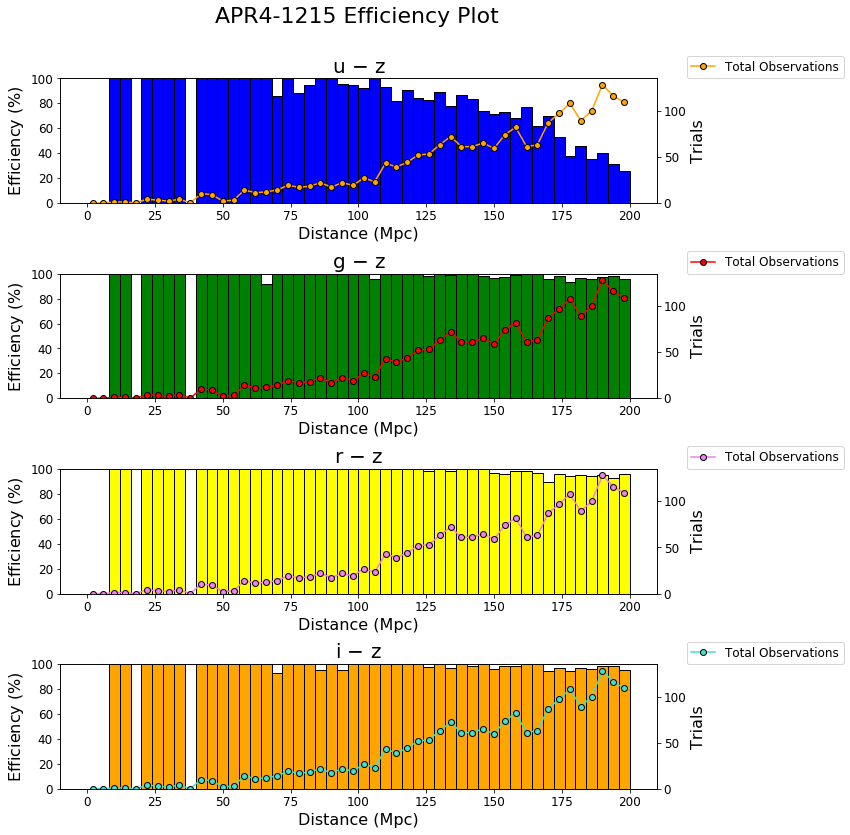

In [15]:
plot_bar2(APR1215_Data, "APR4-1215")

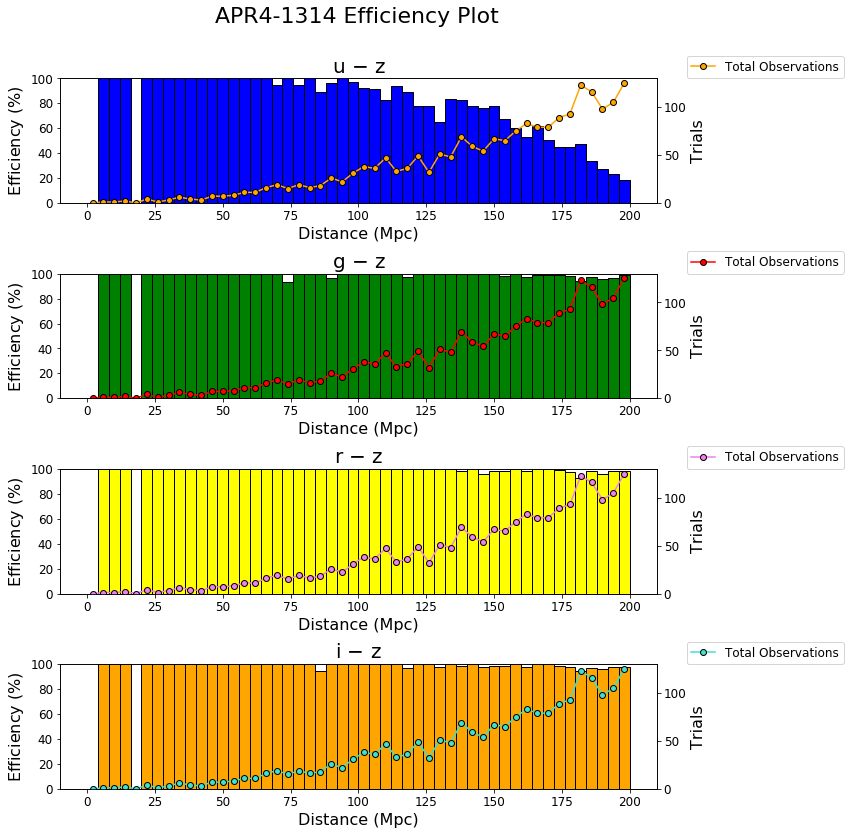

In [16]:
plot_bar2(APR1314_Data, "APR4-1314")

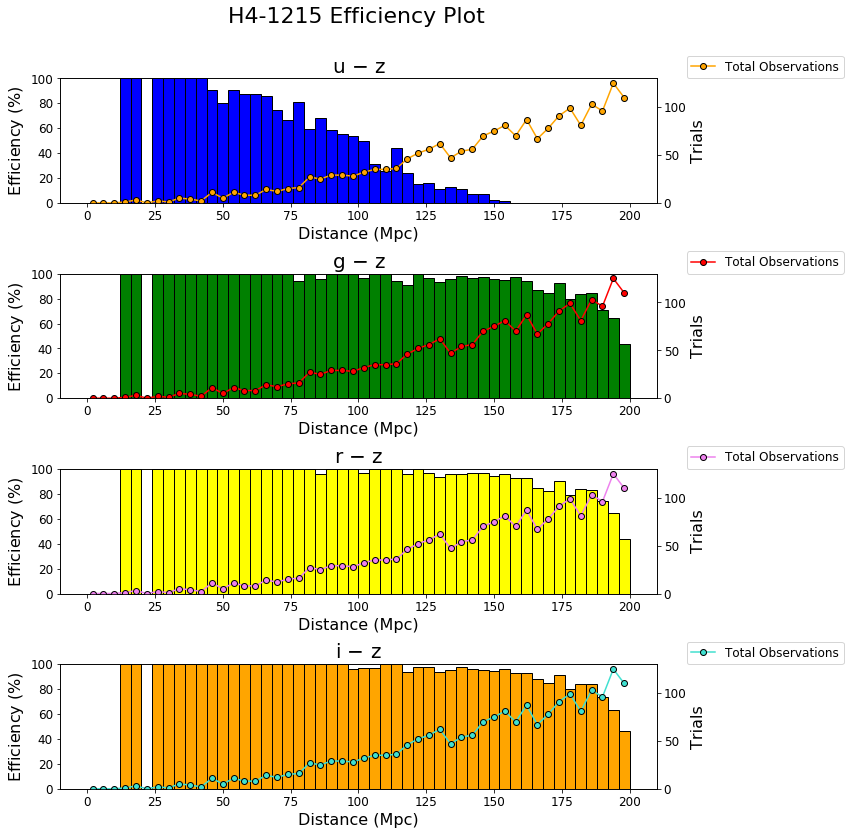

In [17]:
plot_bar2(H41215_Data, "H4-1215")

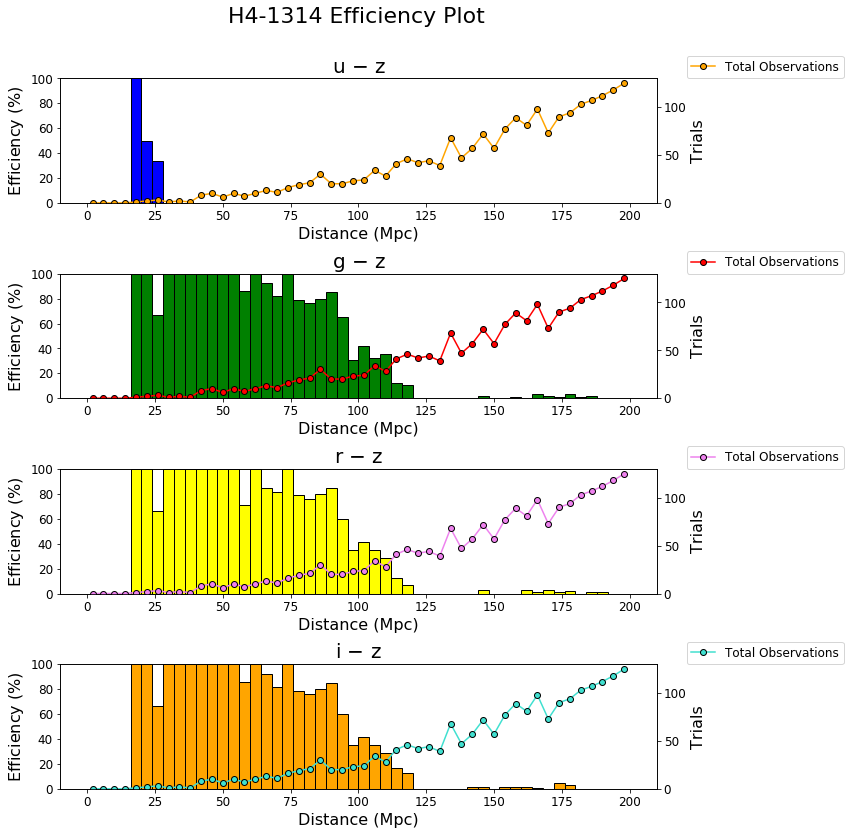

In [18]:
plot_bar2(H41314_Data, "H4-1314")

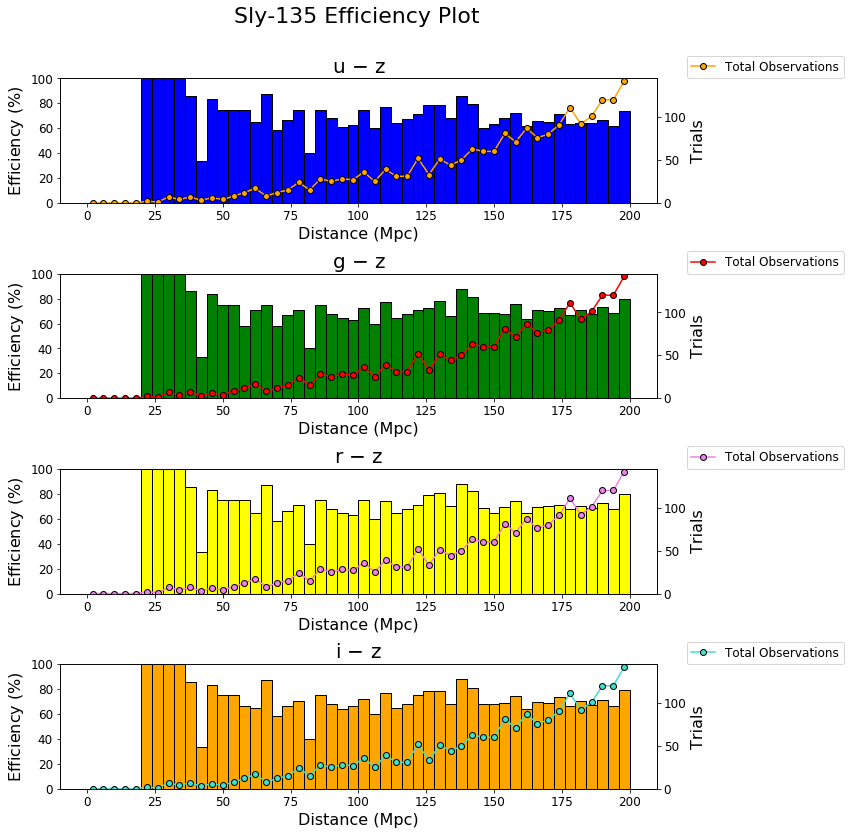

In [19]:
plot_bar2(Sly135_Data, "Sly-135")

### NS-BH Efficiency Plots

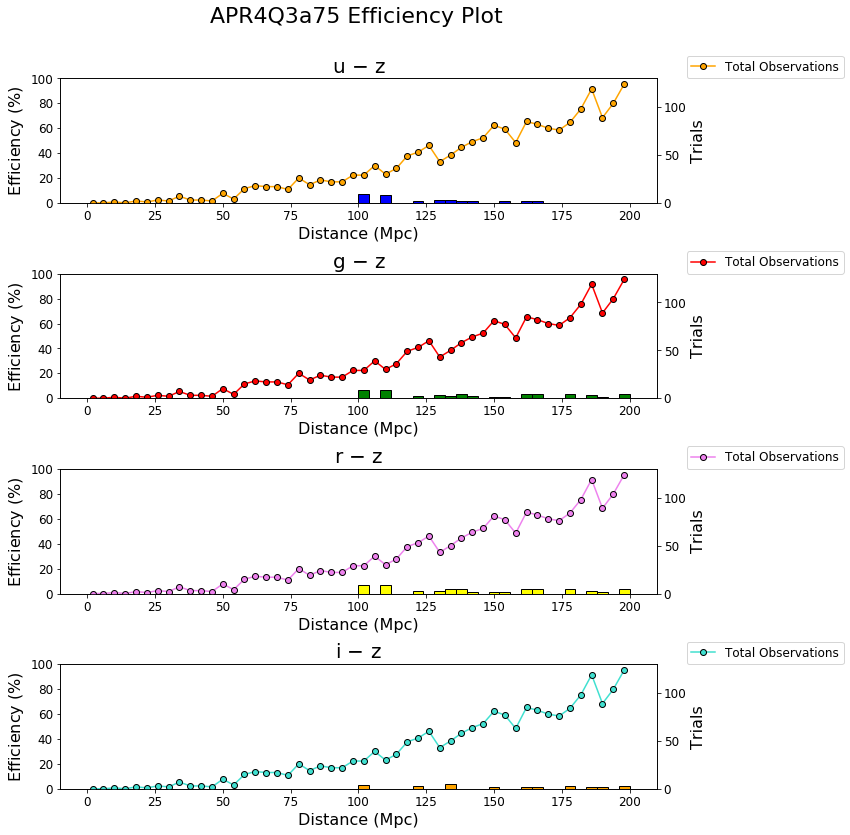

In [20]:
plot_bar2(APR4Q3a75_Data, "APR4Q3a75")

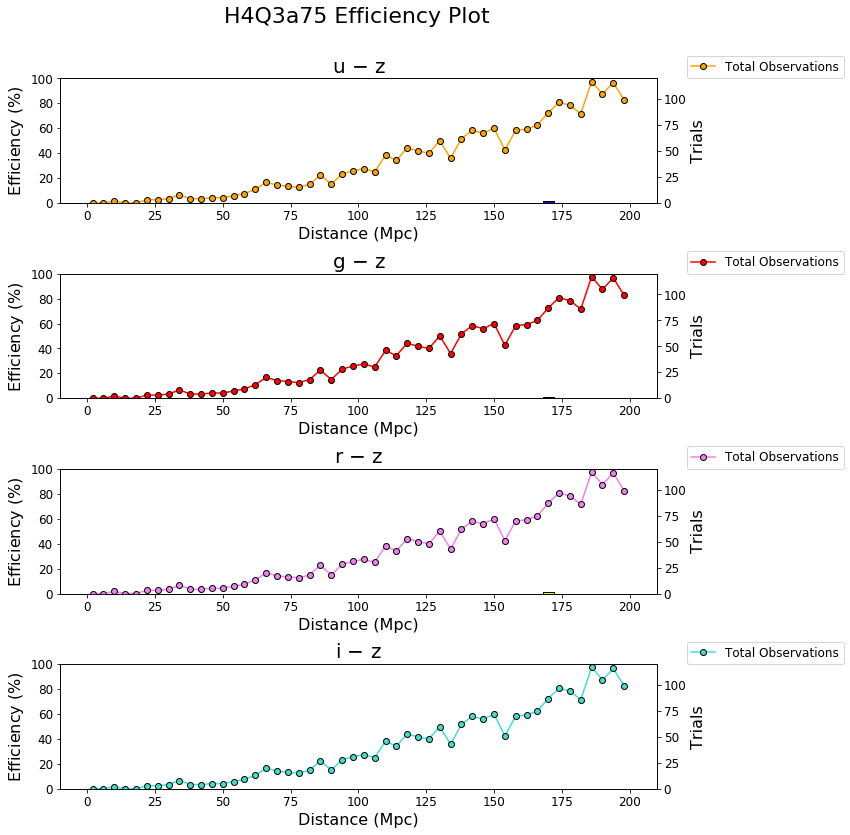

In [21]:
plot_bar2(H4Q3a75_Data, "H4Q3a75")

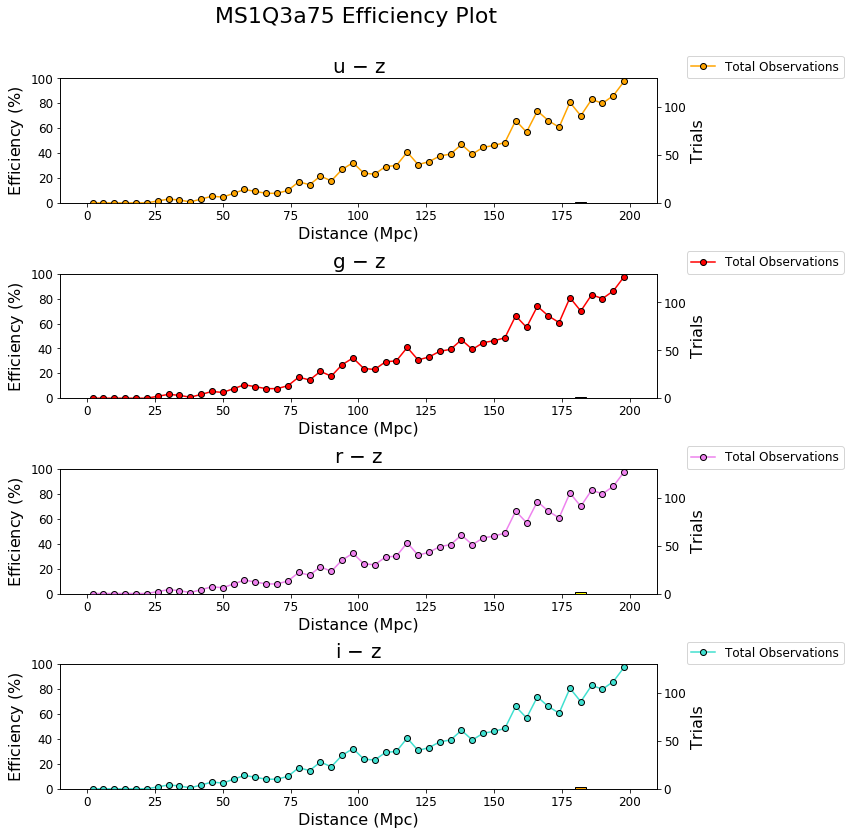

In [22]:
plot_bar2(MS1Q3a75_Data, "MS1Q3a75")

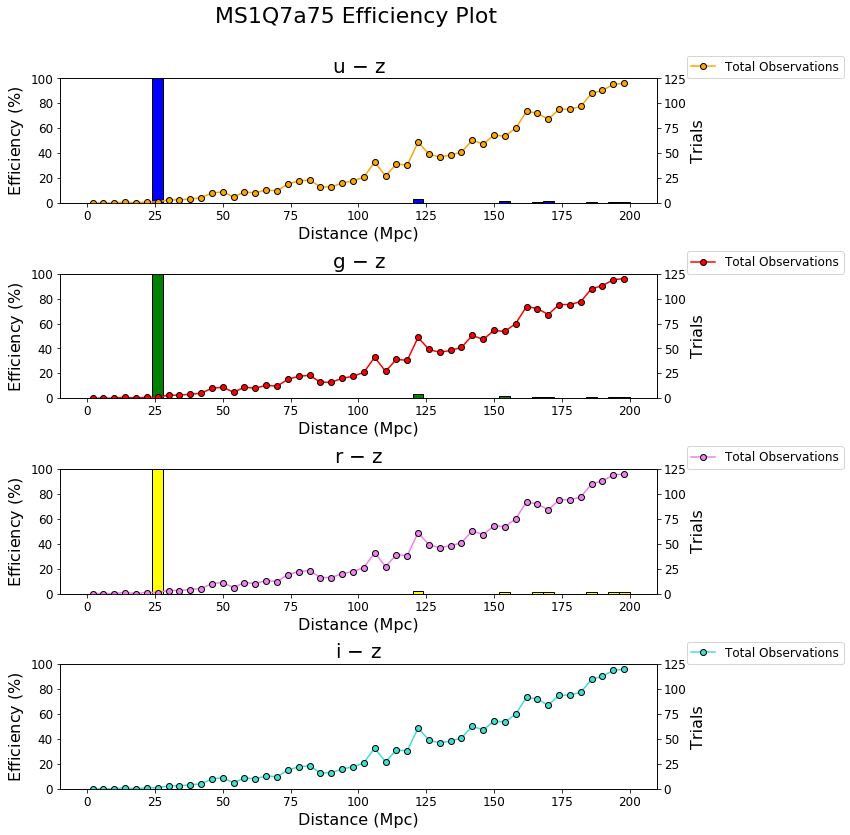

In [24]:
plot_bar2(MS1Q7a75_Data, "MS1Q7a75")

In [46]:
NS_NS = {'APR4-1215': APR1215_Data, 
         'APR4-1314': APR1314_Data,
         'H4-1215': H41215_Data,
         'H4-1314': H41314_Data,
         'Sly-135': Sly135_Data}

NS_BH = {'APR4Q3a75': APR4Q3a75_Data, 
         'H4Q3a75': H4Q3a75_Data,
         'MS1Q3a75': MS1Q3a75_Data,
         'MS1Q7a75': MS1Q7a75_Data}

In [159]:
def merger_averages():
    NSNS = averages(NS_NS, 'NS-NS')
    NSBH = averages(NS_BH, 'NS-BH')
    mergers = vstack([NSNS, NSBH])
    mergers.add_row(['NS-NS', 'Total Avg.',
                    np.mean(NSNS['u-z']), np.mean(NSNS['g-z']), np.mean(NSNS['r-z']), np.mean(NSNS['i-z']),
                    np.mean(NSNS['Object Average'])])
    mergers.add_row(['NS-BH', 'Total Avg.',
                    np.mean(NSBH['u-z']), np.mean(NSBH['g-z']), np.mean(NSBH['r-z']), np.mean(NSBH['i-z']),
                    np.mean(NSBH['Object Average'])])
    mergers = mergers.to_pandas()
    return mergers

def averages(mergers, name):
    averages = Table([[],[],[],[],[]], names=('u-z', 'g-z', 'r-z', 'i-z', 'Object Average'))
    for key,value in mergers.items():
        averages = vstack([averages,average(value, key, name)])
    averages = averages['Merger', 'Object ID', 'u-z', 'g-z', 'r-z', 'i-z', 'Object Average']
    return averages


def average(table, key, name):
    u = []
    g = []
    r = []
    i = []
    total = []
    objectid = []
    name1 = []
    
    u.append(np.mean(efficiency2(table, 'u-z')[0]))
    g.append(np.mean(efficiency2(table, 'g-z')[0]))
    r.append(np.mean(efficiency2(table, 'r-z')[0]))
    i.append(np.mean(efficiency2(table, 'i-z')[0]))
    
    total.append(np.mean(np.array([u[0], g[0], r[0], i[0]])))
    objectid.append(key)
    name1.append(name)
    
    return Table([name1,objectid,u,g,r,i,total],
                 names=('Merger', 'Object ID', 'u-z', 'g-z', 'r-z', 'i-z', 'Object Average'))

In [167]:
import pandas as pd
writer = pd.ExcelWriter('3_day.xlsx')
merger_averages().to_excel(writer, 'Sheet1')